In [2]:
import scipy
import pandas as pd
import requests
import datetime
import zoneinfo
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import exponweib
import pytz
import altair as alt

In [51]:
parameters = {"api_key": "insert api key here"}

# How late can you arrive at the Airport tomorrow and still catch your flight?

### Malcolm Ramsay

# Never...
## Stay in Adelaide

## Step 1: Research

How early do people arrive for a flight?

- Most commonly 1 1/4 hours

- This is from a study from Bologna "Marconi" Airport in Italy at Christmas Time...



<https://www.sciencedirect.com/science/article/pii/S2352146518306173>

In [9]:
dist = (
    [2.25] * 1 +
    [2] * 4 +
    [1.75] * 10 +
    [1.5] * 26 +
    [1.25] * 30 +
    [1.0] * 19 +
    [0.75] * 10 +
    [0.5] * 1
)

In [10]:
r = scipy.stats.fit(scipy.stats.weibull_max, np.array(dist), [(0, 10), (0, 5), (0, 5)])
distribution = scipy.stats.weibull_max(c=r.params.c, loc=r.params.loc, scale=r.params.scale)

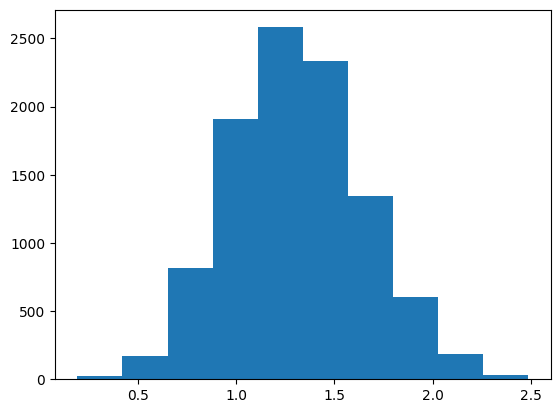

In [11]:
plt.hist(distribution.rvs(10000));

## Step 2: Data Collection

Which flights are leaving Adelaide?

- FlightAware has an API, can get all flights leaving from Adelaide Airport

How many passengers on a flight?

- API has most of the values...

## Step 2a: Manual Data Collection

Surely there aren't that many variations on the number of passengers on a plane?

- There are multiple cabin configurations within a single airline

Close enough will do

In [12]:
aircraft_data = {
    # QantasLink Dash8
    "DH8C": 74,
    # QantasLink Embraer 190
    "E190": 88,
    # Rex Saab SF340 v2
    "SF34": 33,
    # Airbus A320
    "A320": 180,
    # Beoing 737-800 
    "B738": 138,
    # Virgin Boeing 737-800
    "B737": 168,
    # Qatar Boing 777-300
    "B77W": 350,
    "B733": 12 + 168,
    "B463": 100,
    "F100": 100,
    "A21N": 232,
}

## Step 3: Make Assumptions

1. There are only domestic flights
2. Planes are not quite full (95%)
3. You don't have to check bags or check in (add extra time for these)
4. We want to be through security 20 minutes before departure
5. Target queue time is 15 minutes

In [13]:
parameters["flight_capacity"] = 0.95
parameters["boarding_time"] = datetime.timedelta(minutes=20)
parameters["target_queue"] = 15

## Step 4: Model Building

For each person coming to the airport

- Pick how early they arrive from our distribution
- Subtract that from their flight time

Count up all the people for each point in time

In [52]:
session = requests.Session()
session.headers.update({"x-apikey": parameters["api_key"]})
                    
def get_jobs():
    url = "https://aeroapi.flightaware.com/aeroapi/airports/YPAD/flights/scheduled_departures"
    params = {
        "start": start_time.astimezone(datetime.UTC).strftime("%Y-%m-%dT%H:%M:%SZ"),
        "end": end_time.astimezone(datetime.UTC).strftime("%Y-%m-%dT%H:%M:%SZ"),
        "max_pages": 10,
    }

    first_page = session.get(url, params=params).json()
    yield first_page
    num_pages = first_page['num_pages']
    if first_page['links'] is not None:
        next = first_page['links'].get('next')
    else:
        next = None
    while next is not None:
        next_page = session.get(next)
        yield next_page
        if next_page['links'] is not None:
            next = next_page['links'].get('next')
        else:
            next = None

In [15]:
start_time = datetime.datetime(year=2023, month=8, day=20, hour=5, minute = 0, tzinfo=pytz.timezone("Australia/Adelaide"))
end_time = start_time + datetime.timedelta(hours=24)

In [16]:
flight_dfs = []
flights = []
rng = np.random.default_rng()

for page in get_jobs():
    for f in page["scheduled_departures"]:
        flights.append(f)
        if f['aircraft_type'] is None:
            continue
        if f["seats_cabin_coach"] is not None and (seats := f["seats_cabin_first"] + f["seats_cabin_business"] + f["seats_cabin_coach"])> 0:
            f['seats'] = seats
            # print(f"Found seat data for flight {f['ident_iata']}")
        elif (seats := aircraft_data.get(f['aircraft_type'].strip(), 0)) > 0:
            f['seats'] = seats
        else:
            raise ValueError(f"No seats found for {f}")
            
        if f['scheduled_out'] is not None:
            f['dep'] = datetime.datetime.fromisoformat(f['scheduled_out']).astimezone(pytz.timezone("Australia/Adelaide"))
        else: 
            f['dep'] = datetime.datetime.fromisoformat(f['scheduled_off']).astimezone(pytz.timezone("Australia/Adelaide"))
        
        people = pd.DataFrame({
            "flight": f['ident_iata'],
            "departure": f['dep'],
            "aircraft": f['aircraft_type'],
            "pre_arrival": (distribution.rvs(int(f['seats'] * parameters['flight_capacity'])) * 60).round().astype(int),
        })
        people = people.assign(arrival = lambda x: x['departure'] - x['pre_arrival'].apply(lambda y: pd.Timedelta(y, unit="minute")))
        flight_dfs.append(people)
        #print(f"Operator: {f['operator']}, Flight: {f['ident_iata']}, Aircraft: {f['aircraft_type']}, Seats: {f['seats']}, Departure: {f['dep']}")

In [17]:
df_passengers = pd.concat(flight_dfs)

In [41]:
df_arrivals = df_passengers.set_index("arrival").resample("1min").count().reset_index()

In [46]:
alt.Chart(
    df_arrivals.set_index("arrival").rolling(11).mean().reset_index()
).mark_line().encode(
    x=alt.X("arrival", title="Time Arrive at Airport"),
    y=alt.Y("aircraft", title="Passengers per minute"),
).properties(width=800, height=400).configure_axis(labelFontSize=14)

alt.Chart(...)

## Step 5: Check our Question?

We know when people are arriving at security.

What now need to work out:
1. how long is the queue, and
2. when is the optimal time to join.

## Step 6: More Research

How many people can we get through a security lane?

- on average 2.5 per minute

How many lanes at Adelaide Airport?

- 7 (one is hiding)

In [22]:
parameters["lane_throughput"] = 2.5
parameters["max_lanes"] = 7

## Step 7: Another Model

We need to model people queueing at security.

Not all lanes will always be open, so need to scale approriately.

- When the queue gets too long we add another lane
- Where there is no demand we take them away

In [44]:
queue = 0
lanes = 4
# We know there is a stream of people in the morning so ensure all the lanes are open
cooldown = 60
df_arrivals["queue"] = 0
for index, row in df_arrivals.iterrows():
    throughput = parameters["lane_throughput"] * lanes
    queue = max(0, queue + row.pre_arrival - throughput)
    queue_time = queue / throughput
    df_arrivals.loc[index, "queue"] = queue
    df_arrivals.loc[index, "throughput"] = throughput
    if cooldown == 0:
        if queue_time > parameters["target_queue"] and lanes < parameters["max_lanes"]:
            lanes += 1   
            cooldown += 2 * lanes
        elif queue_time < 5 and 2 < lanes:
            lanes -= 1
    else:
        cooldown -= 1
df_arrivals["queue_time"] = df_arrivals["queue"] / df_arrivals["throughput"]

In [45]:
alt.Chart(df_arrivals).mark_line().encode(
    x=alt.X("arrival", title="Time Arrive at Airport"), 
    y=alt.Y("queue_time", title="Queue Time"),
).properties(width=800, height=400).configure_axis(labelFontSize=14)

alt.Chart(...)

In [28]:
df_flights = pd.DataFrame.from_dict(flights)
df_flights["boarding"] = pd.to_datetime(df_flights["dep"]) - parameters["boarding_time"]
df_arrivals["through"] = df_arrivals["arrival"] + df_arrivals["queue_time"].apply(lambda x: pd.Timedelta(x, unit="minute"))

In [34]:
arrival_times = []
for _, flight in df_flights.iterrows():
    terminal_time = flight["boarding"] - df_arrivals["through"]
    mask = terminal_time > pd.Timedelta(0)
    index = terminal_time[mask].idxmin()
    arrival_times.append({
        "flight": flight["ident_iata"],
        "departing": flight["dep"].time(),
        "destination": flight["destination"]["code_iata"],
        "join security snake": df_arrivals.iloc[index, :]["arrival"].time(),
        "at security": df_arrivals.iloc[index, :]["through"].time().replace(second=0, microsecond=0),
    })

## When should I arrive?

In [53]:
earliest_time = datetime.time(hour=16)
pd.DataFrame.from_dict(arrival_times).query("departing >= @earliest_time").sort_values("departing")

,flight,departing,destination,join security snake,at security
56,QQ3240,16:00:00,OLP,15:34:00,15:39:00
57,QF690,16:05:00,MEL,15:37:00,15:43:00
58,ZL4388,16:10:00,PLO,15:42:00,15:49:00
59,VA580,16:20:00,CBR,15:51:00,15:59:00
60,QF1976,16:20:00,CBR,15:51:00,15:59:00
61,VA429,16:30:00,SYD,15:59:00,16:09:00
62,JQ765,17:20:00,SYD,16:41:00,16:59:00
63,VA236,17:40:00,MEL,17:00:00,17:19:00
64,QF694,17:45:00,MEL,17:04:00,17:24:00
65,VA1403,17:50:00,BNE,17:08:00,17:29:00
